In [1]:
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
def energia_por_trimestre(X,variable):
    return X.groupby([variable]).sum()

In [3]:
def conteo_ocurrencias(data,trimestres,variable):
    
    recursos_conteo_dict = dict()

    for trimestre in trimestres:
        trimestre_filtrado = data.iloc[data.index.get_level_values('Fecha') == trimestre]
        trimestre_filtrado = trimestre_filtrado.reset_index()

        year = pd.to_datetime(trimestre).year
        if year not in recursos_conteo_dict:
            recursos_conteo_dict[year] = dict()
        
        for recurso in pd.unique(trimestre_filtrado[variable]):
            if recurso in recursos_conteo_dict[year]:
                recursos_conteo_dict[year][recurso] += 1
            else:
                recursos_conteo_dict[year][recurso] = 1
                
    return recursos_conteo_dict

In [4]:
def plot_measures(values,labels,titulo, x_rotation, fig_size=(8,8)):
        
    ind = np.arange(len(labels))  # the x locations for the groups
    width = 0.45  # the width of the bars

    fig, ax = plt.subplots(figsize=fig_size)
    rects1 = ax.bar(ind, values, width,color='SkyBlue')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Conteos')
    ax.set_title(titulo)
    ax.set_xticks(ind)
    ax.set_xticklabels(labels,rotation = x_rotation)
    
    autolabel(rects1,ax, "center")
    plt.show()
    
def autolabel(rects, ax,xpos='center'):
    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                height, ha=ha[xpos], va='bottom')    

In [5]:
def pintar_grafica(datos,trimestres,year,variable_general,variable_especifica):
        
    if len(trimestres)<=3:
        fig, axes= plt.subplots(1, len(trimestres),figsize=(20,10))
    else:
        fig, axes= plt.subplots(2, 2,figsize=(20,20))
        
    
    for i, (ax,trimestre) in enumerate(zip(axes.flatten(),trimestres)):
        
        trimestre_filtrado = datos.iloc[datos.index.get_level_values('Fecha') == trimestre]
        trimestre_filtrado = trimestre_filtrado.reset_index()
        
        pie_labels = pd.unique(trimestre_filtrado[variable_especifica])    
        if len(pie_labels)>12:
            rotatelabels = True
            
            if len(pie_labels)>15:
                trimestre_filtrado.sort_values(by=['kWh'],inplace=True,ascending=False)
                
                cuantil = 0.9
                distribucion_quantiles = trimestre_filtrado['kWh'].quantile([cuantil])
                
                mascara_cuantil = trimestre_filtrado['kWh']>=distribucion_quantiles[cuantil]
                superior_al_cuantil = trimestre_filtrado[mascara_cuantil]                
                inferior_al_cuantil = trimestre_filtrado[~mascara_cuantil]
                
                suma_inferior_al_cuantil = np.sum(inferior_al_cuantil['kWh'])
                
                fila_otros = pd.DataFrame([[trimestre,'Otros',suma_inferior_al_cuantil]],
                                          columns=['Fecha',variable_especifica,'kWh'])
                trimestre_filtrado = superior_al_cuantil.append(fila_otros)
        else:
            rotatelabels = False
        

        explode = np.zeros(len(trimestre_filtrado))
        explode[trimestre_filtrado['kWh'].argmax()] = 0.09

        ax.pie(trimestre_filtrado['kWh'], labels=trimestre_filtrado[variable_especifica], autopct='%1.2f%%',
                shadow=True, startangle=90,rotatelabels=rotatelabels,explode=explode)

        total_khw = np.sum(trimestre_filtrado['kWh'])
        ax.legend(['Total energía {:,} kWh'.format(total_khw)])
    
    plt.tight_layout()   
    plt.suptitle("Total {} Energía Por Trimestres {}".format(variable_general,year), fontsize=15,y=1,fontweight='bold')
    plt.show()

# DESPACHO

In [6]:
data_dir_path = os.path.join('..','dataset','Series','Despacho')

data_list = list()
for file_name in os.listdir(data_dir_path):
    file = pd.read_excel(os.path.join(data_dir_path,file_name))
    data_list.append(file)
    print(os.path.join(data_dir_path,file_name),file.shape)

..\dataset\Series\Despacho\Despacho_0.xlsx (762864, 4)


In [7]:
variable_general = 'Despacho'
full_data = pd.concat(data_list)
filter_df = full_data[full_data['Fecha']>='2018-01-01']

## Análisis por Recurso

In [8]:
data_por_trimestre = filter_df.groupby(pd.Grouper(key="Fecha", freq="3M")).apply(lambda x: energia_por_trimestre(x,'Recurso'))
trimestres = pd.unique(data_por_trimestre.index.get_level_values('Fecha'))

In [9]:
recursos_conteo_dict = conteo_ocurrencias(data_por_trimestre,trimestres,'Recurso')

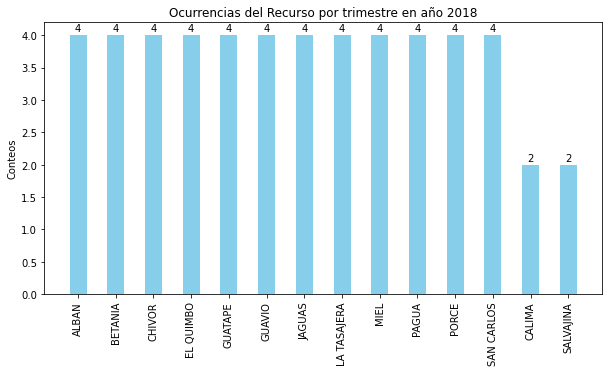

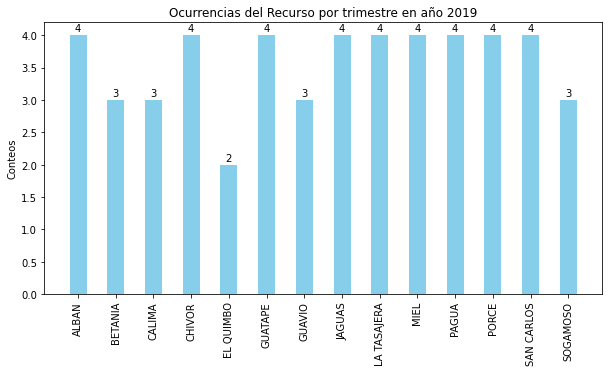

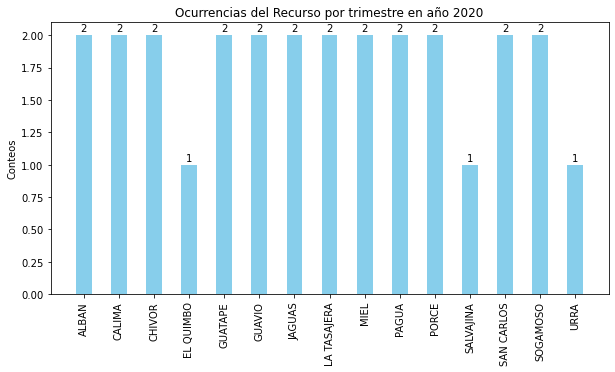

In [10]:
for key,value in recursos_conteo_dict.items():
    title = 'Ocurrencias del Recurso por trimestre en año {}'.format(key)
    labels = value.keys()
    values = value.values()
    plot_measures(values,labels,title,x_rotation=90,fig_size=(10,5))

In [11]:
variable_especifica = 'Recurso'

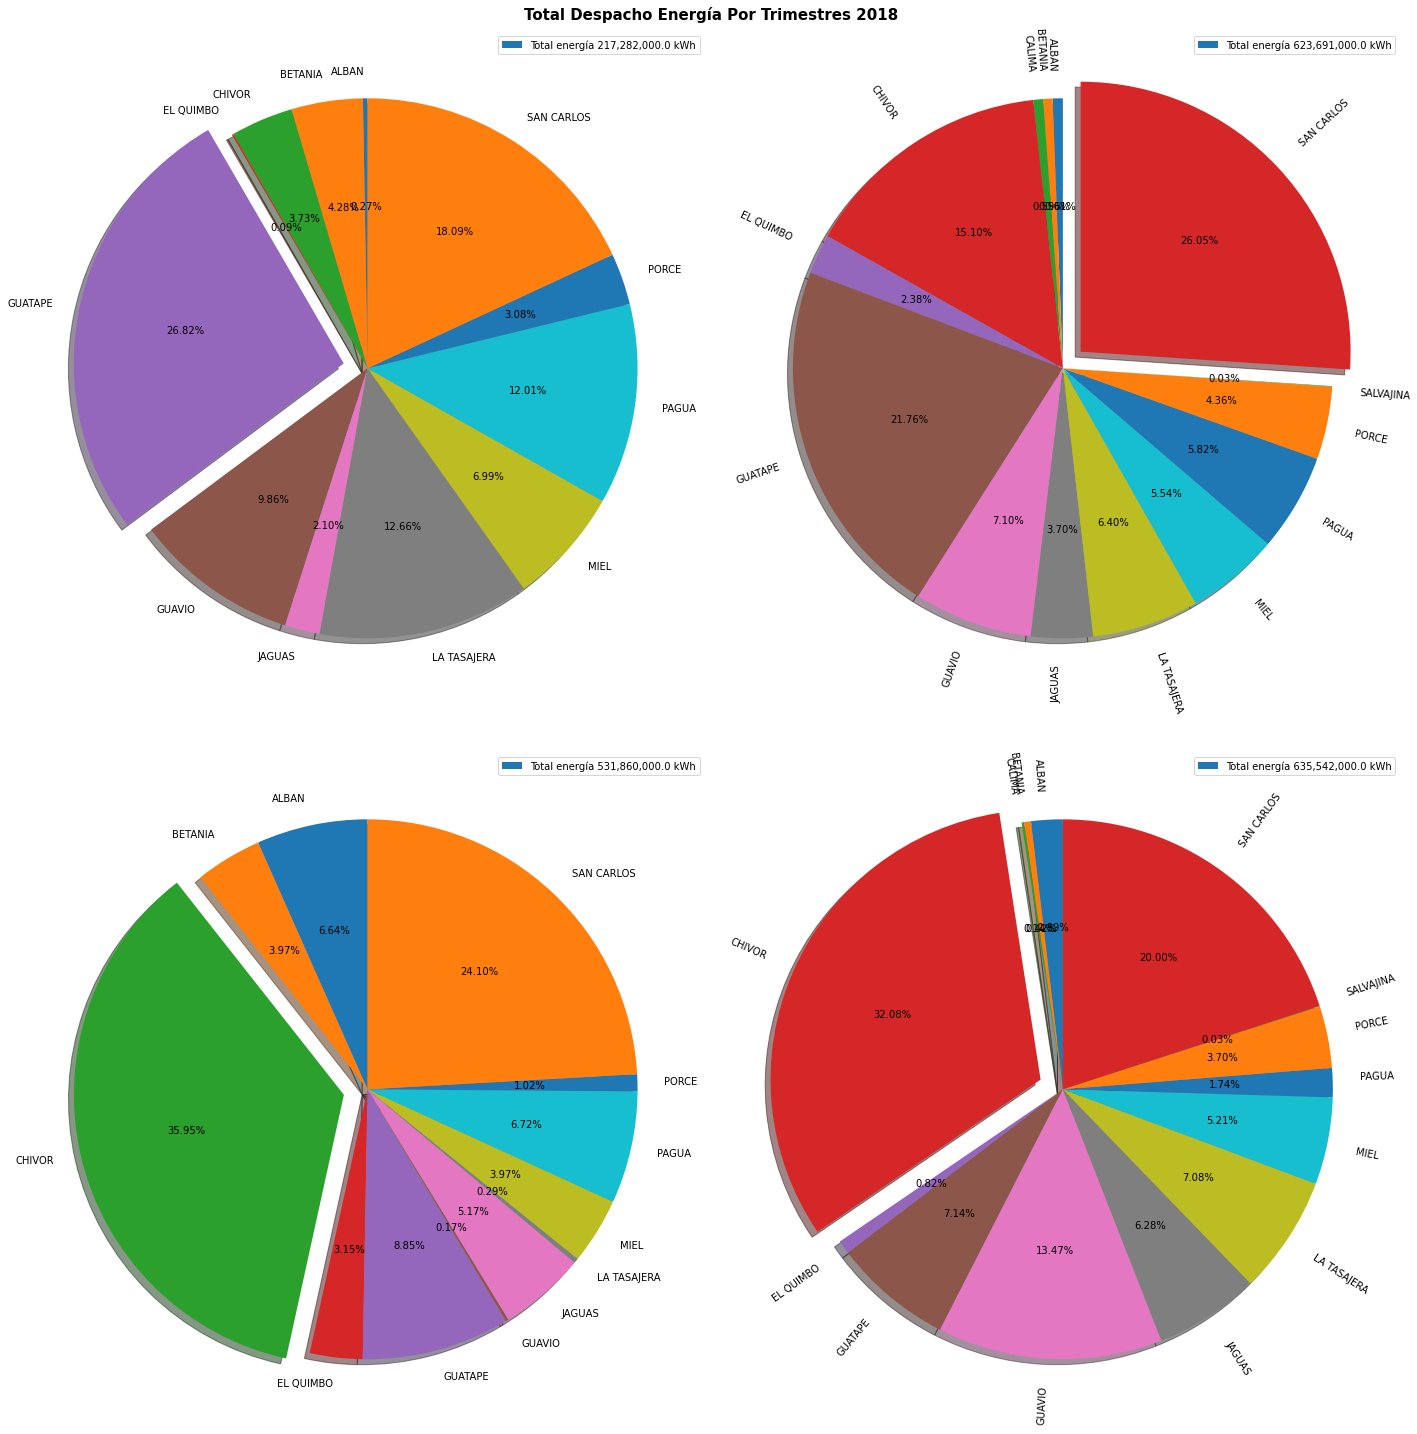

In [12]:
trimestres = ['2018-01-31','2018-04-30','2018-07-31','2018-10-31']
pintar_grafica(data_por_trimestre,trimestres,'2018',variable_general,variable_especifica)

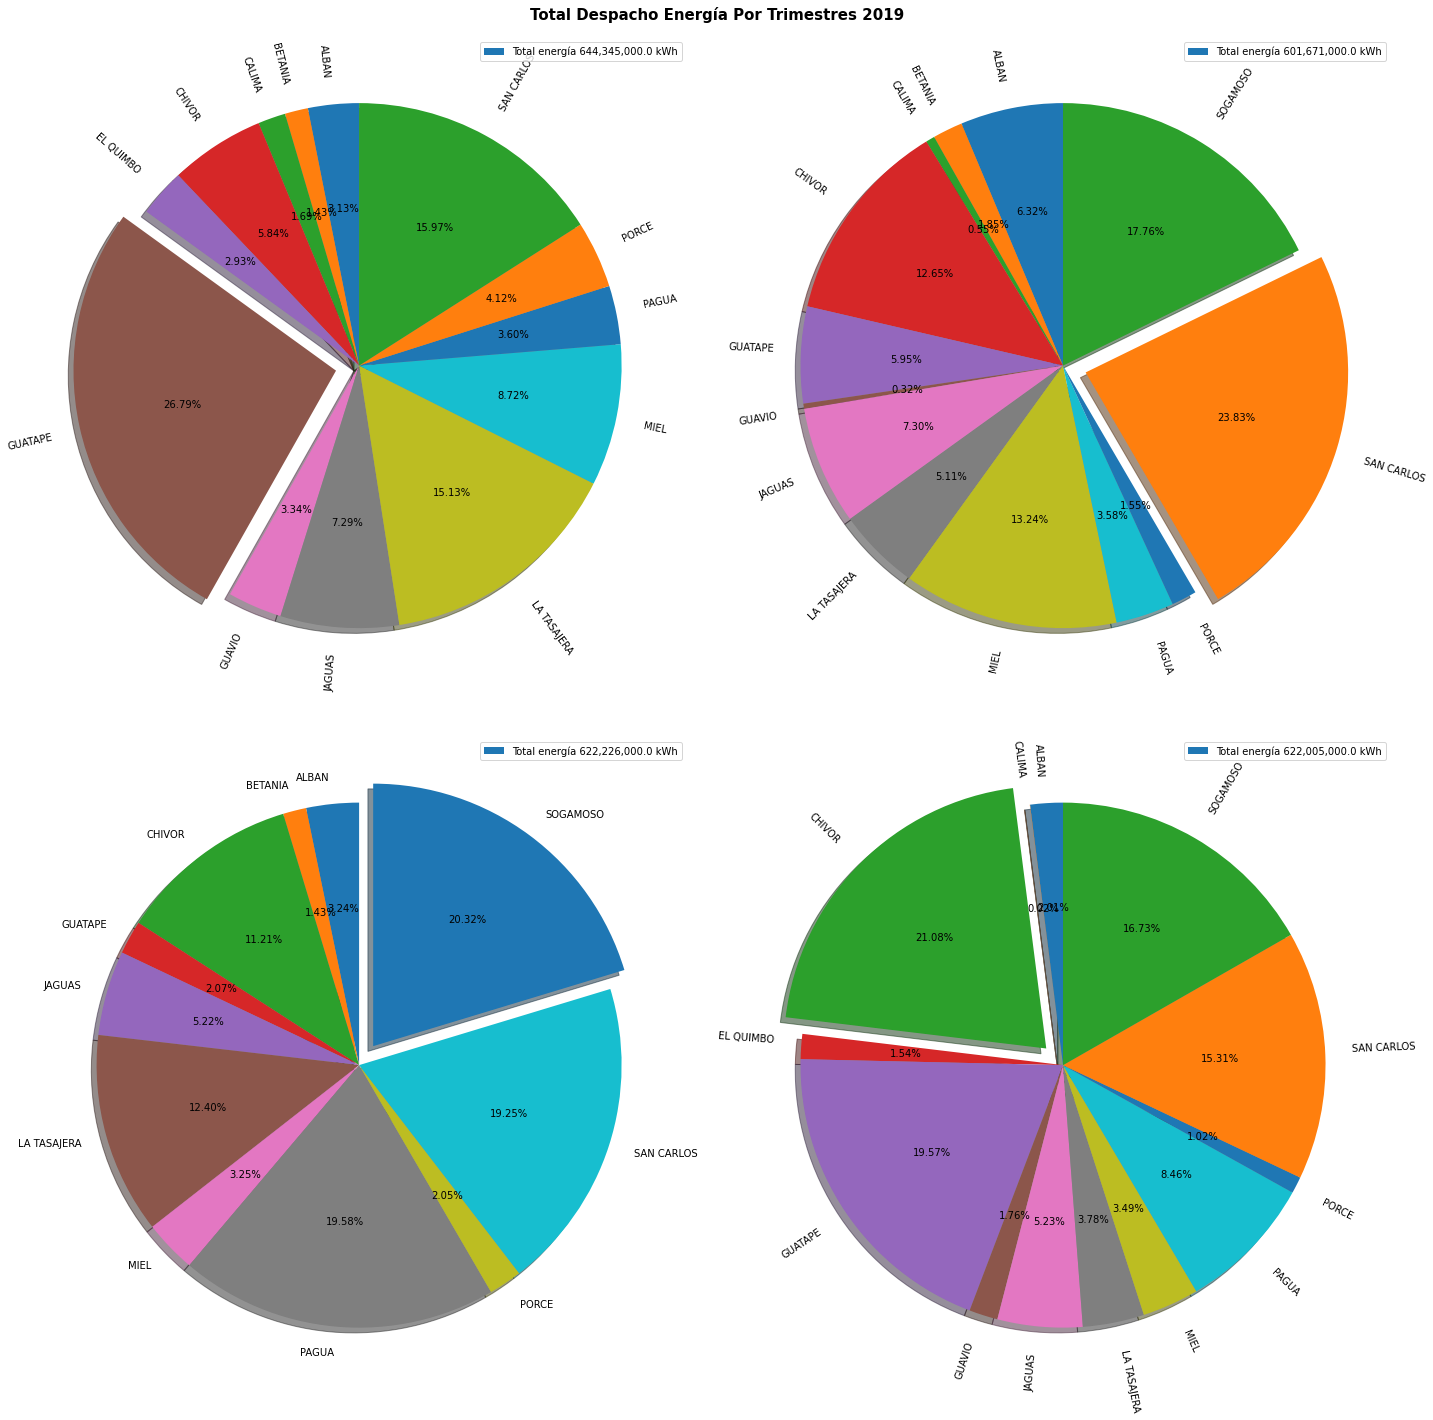

In [13]:
trimestres = ['2019-01-31','2019-04-30','2019-07-31','2019-10-31']
pintar_grafica(data_por_trimestre,trimestres,'2019',variable_general,variable_especifica)

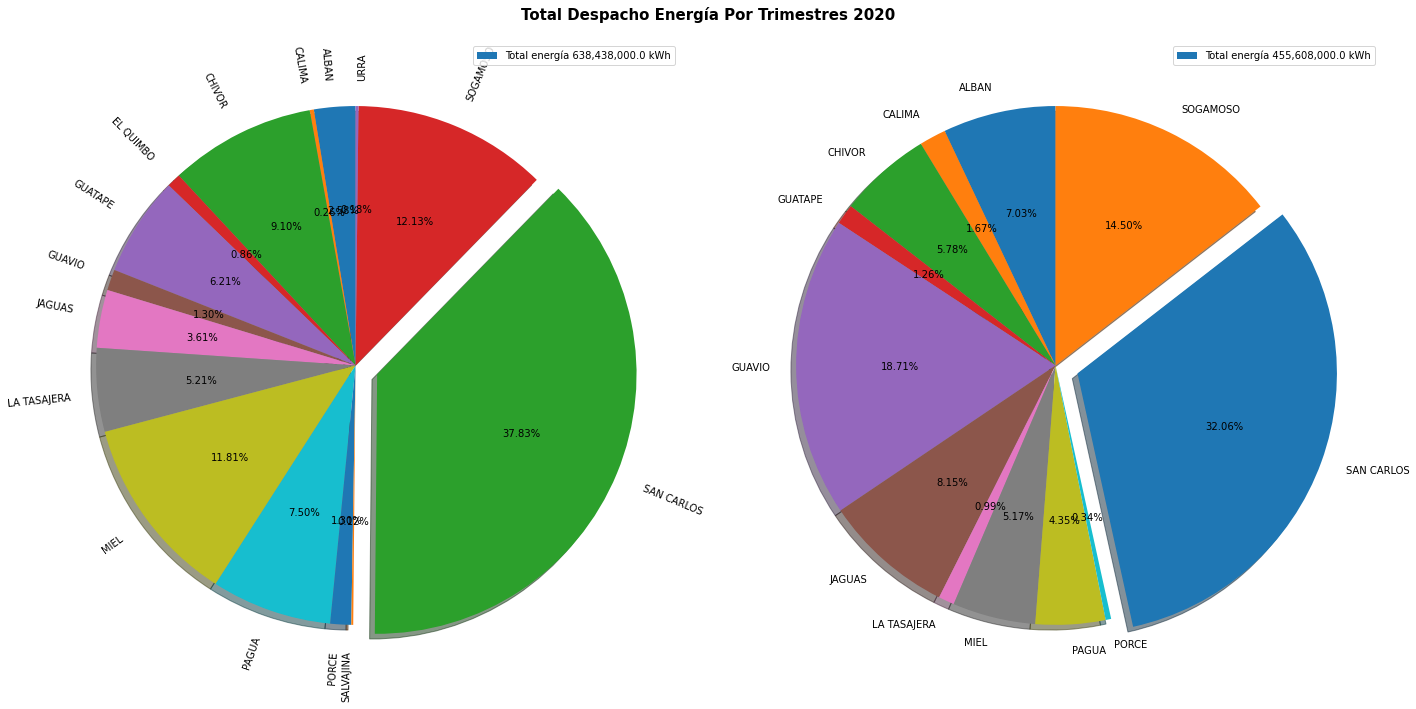

In [14]:
trimestres = ['2020-01-31','2020-04-30']
pintar_grafica(data_por_trimestre,trimestres,'2020',variable_general,variable_especifica)

## Análisis por Agente

In [15]:
data_por_trimestre = filter_df.groupby(pd.Grouper(key="Fecha", freq="3M")).apply(lambda x: energia_por_trimestre(x,'Código Agente'))
trimestres = pd.unique(data_por_trimestre.index.get_level_values('Fecha'))

In [16]:
conteo_dict = conteo_ocurrencias(data_por_trimestre,trimestres,'Código Agente')

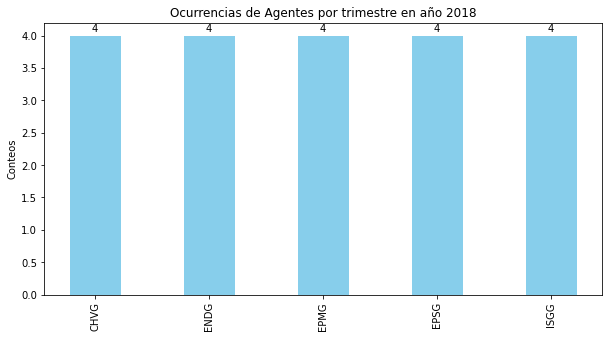

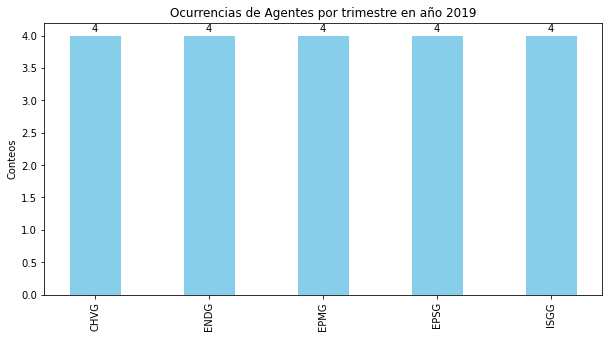

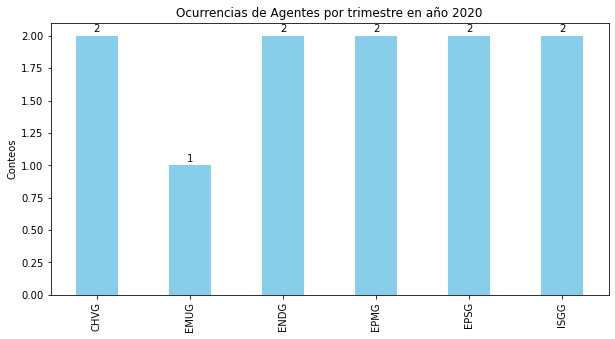

In [17]:
for key,value in conteo_dict.items():
    title = 'Ocurrencias de Agentes por trimestre en año {}'.format(key)
    labels = value.keys()
    values = value.values()
    plot_measures(values,labels,title,x_rotation=90,fig_size=(10,5))

In [18]:
variable_especifica = 'Código Agente'

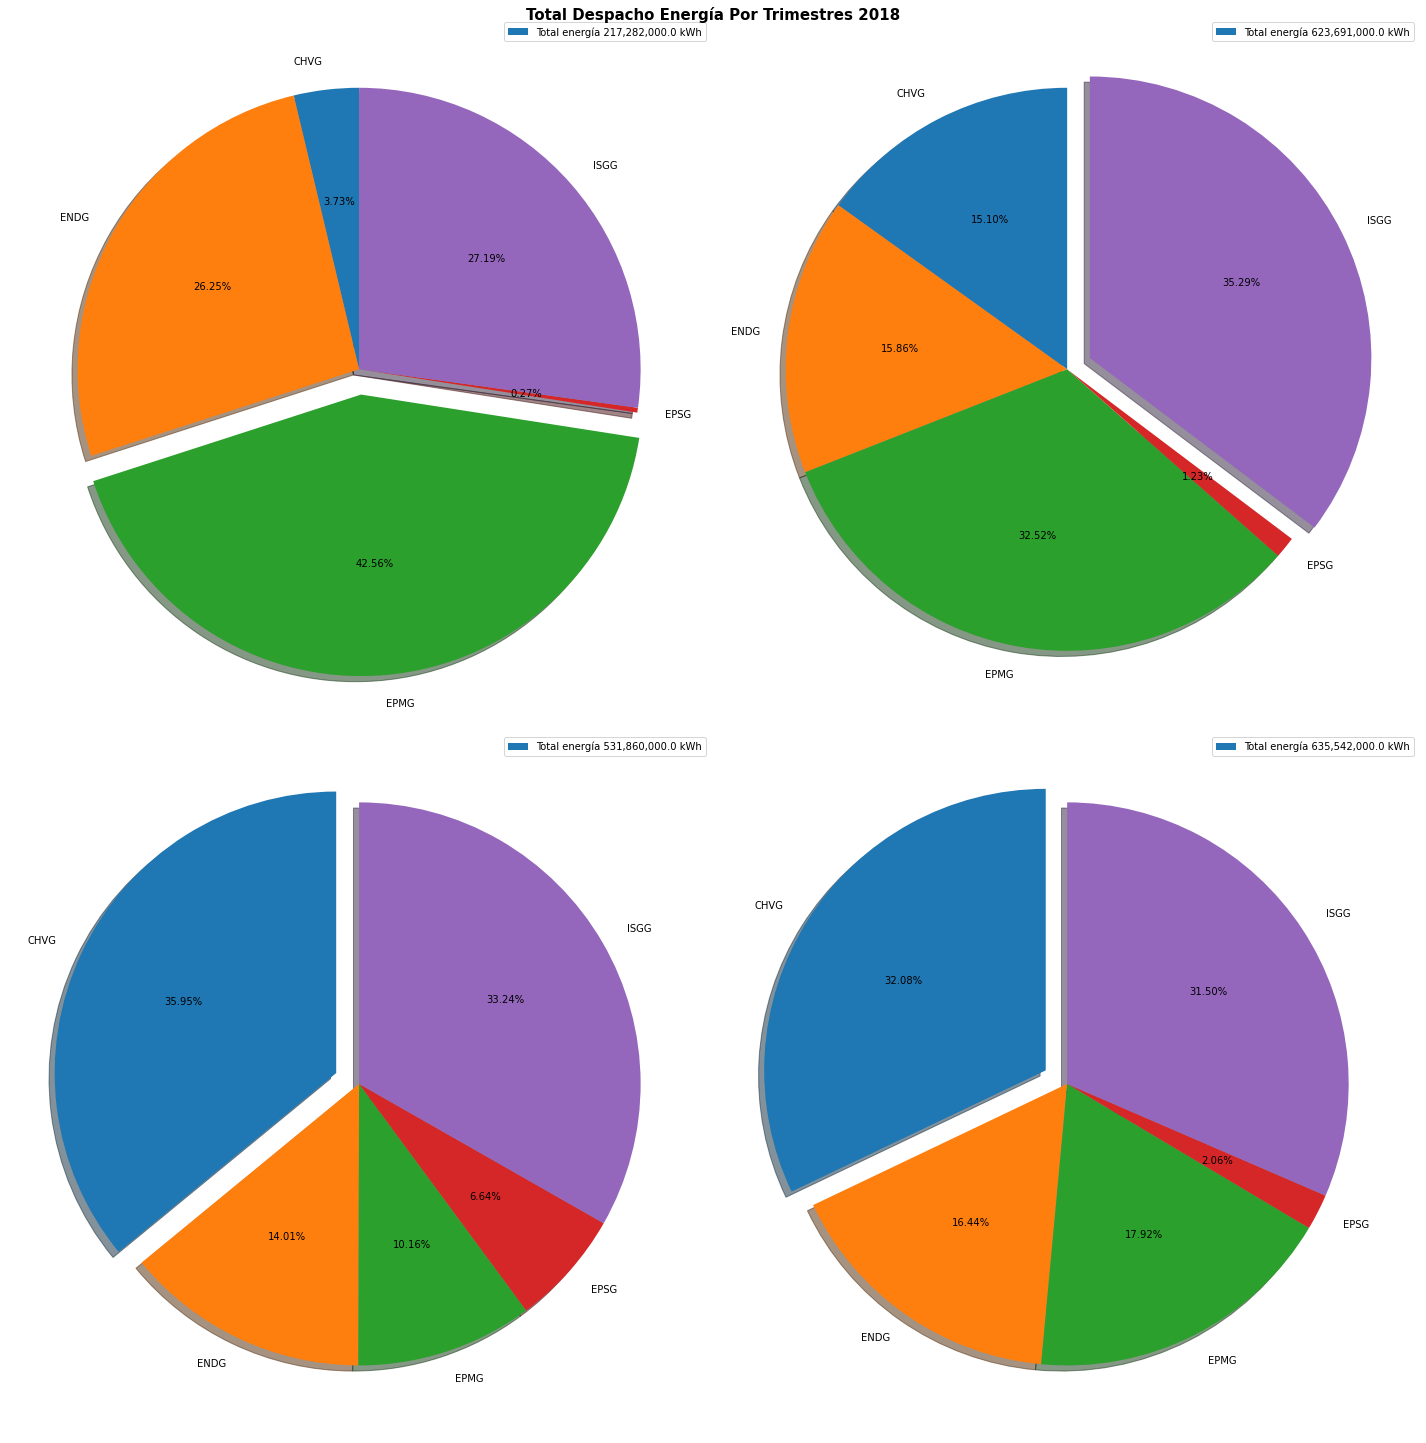

In [19]:
trimestres = ['2018-01-31','2018-04-30','2018-07-31','2018-10-31']
pintar_grafica(data_por_trimestre,trimestres,'2018',variable_general,variable_especifica)

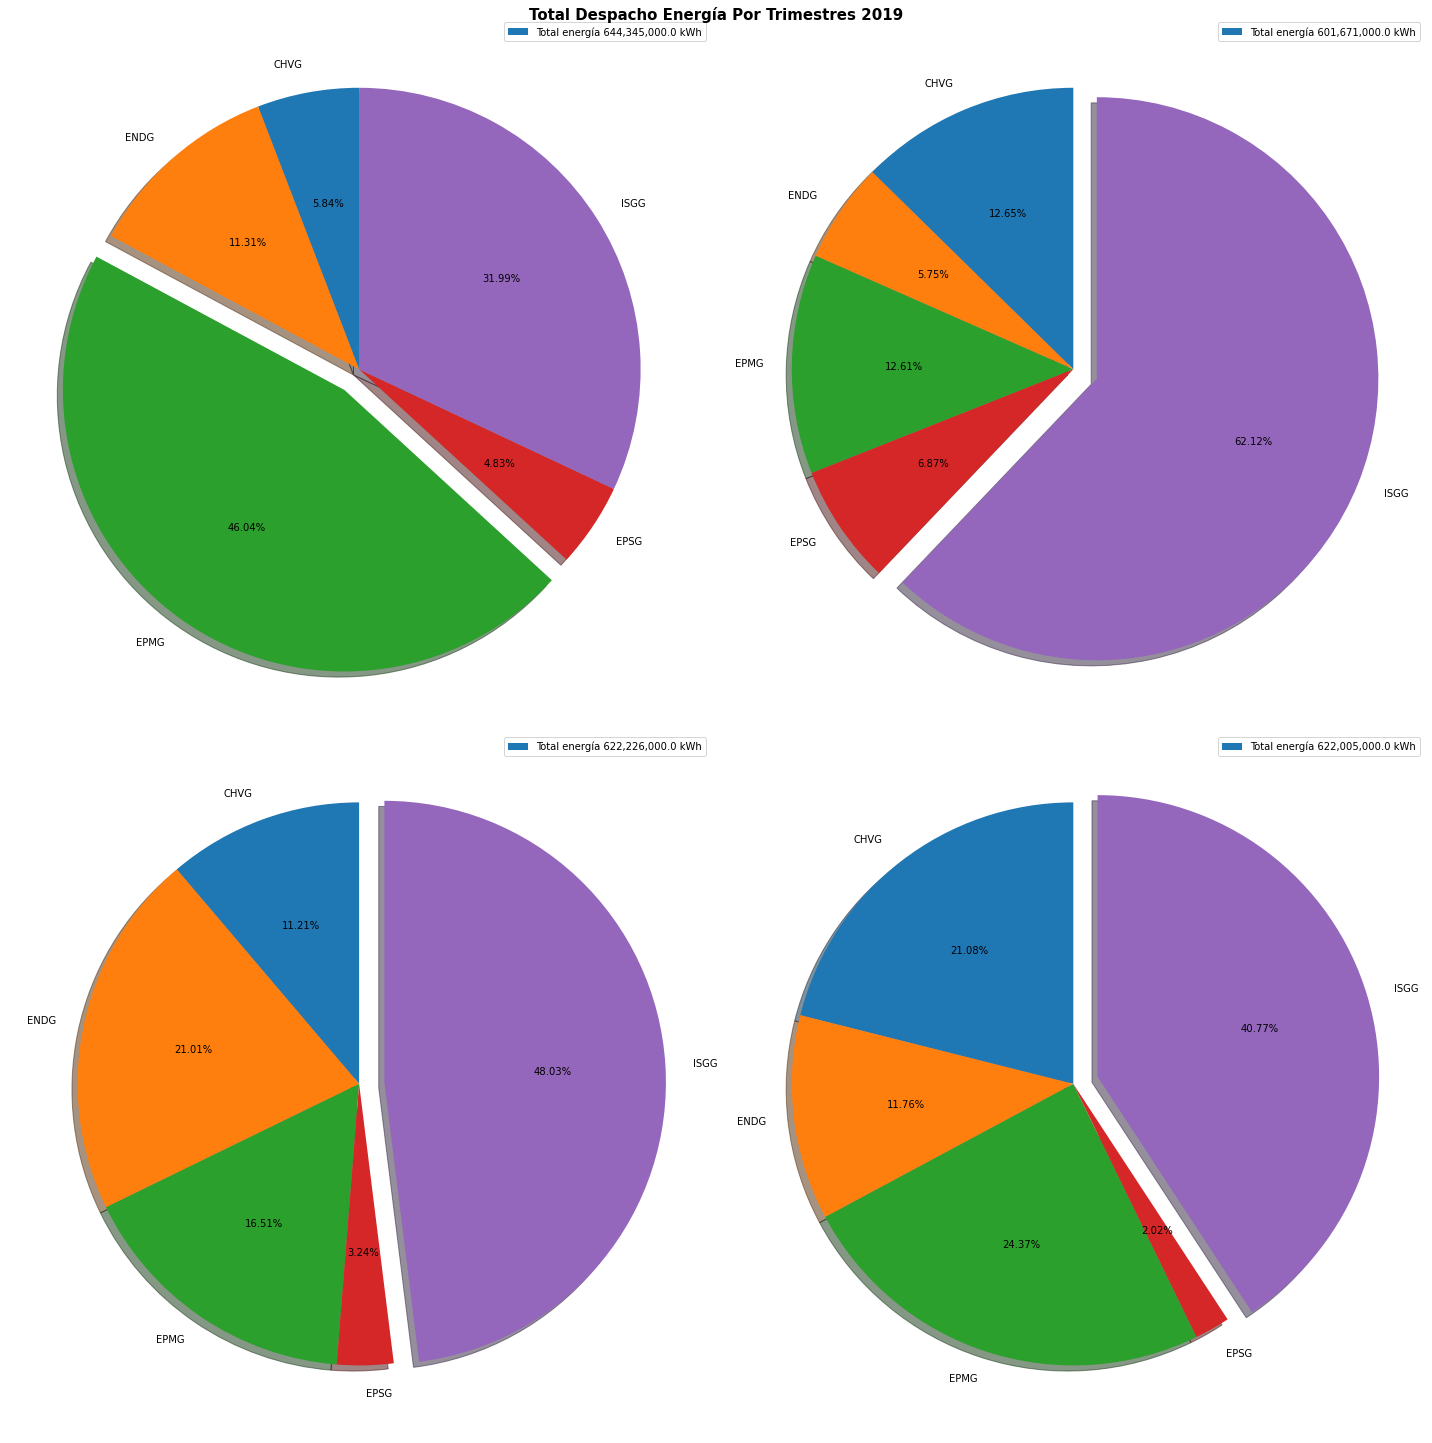

In [20]:
trimestres = ['2019-01-31','2019-04-30','2019-07-31','2019-10-31']
pintar_grafica(data_por_trimestre,trimestres,'2019',variable_general,variable_especifica)

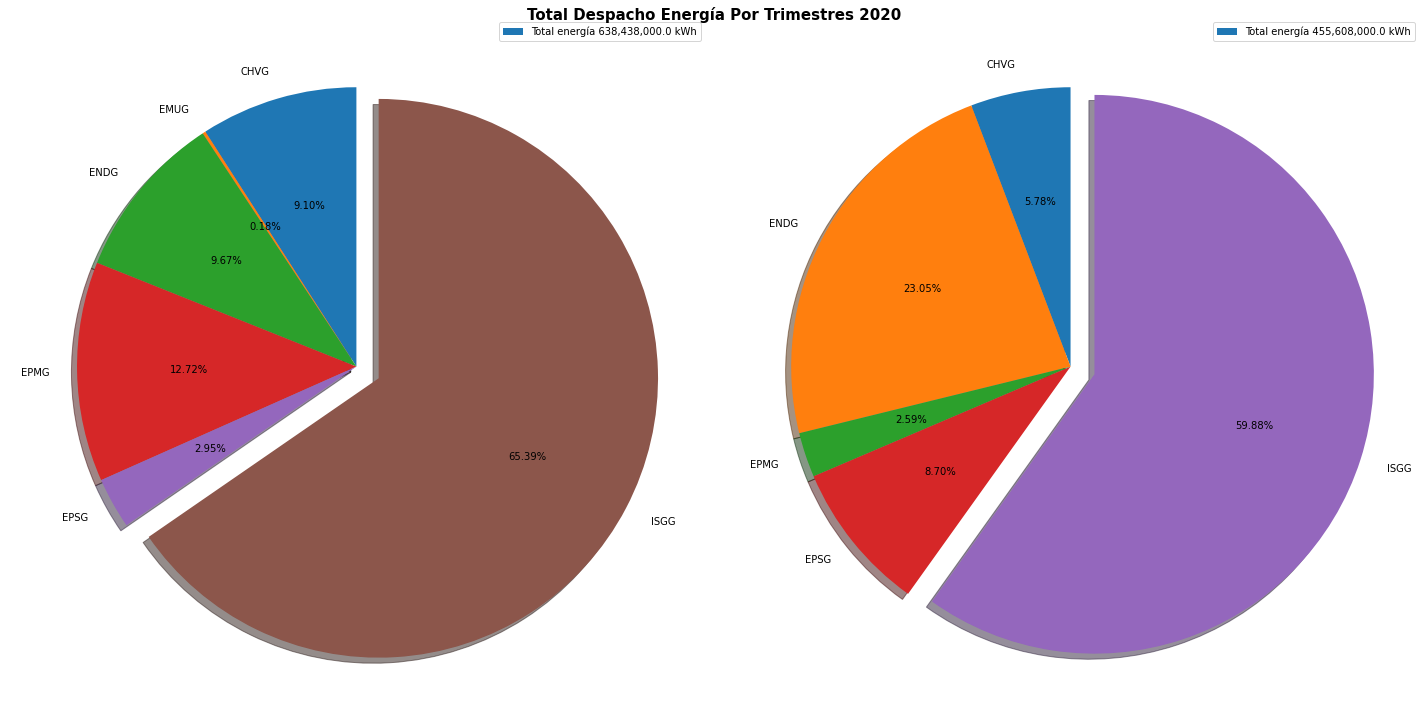

In [21]:
trimestres = ['2020-01-31','2020-04-30']
pintar_grafica(data_por_trimestre,trimestres,'2020',variable_general,variable_especifica)

# GENERACIÓN

In [22]:
data_dir_path = os.path.join('..','dataset','Series','Generacion')

data_list = list()
for file_name in os.listdir(data_dir_path):
    if 'HIDRAULICA' in file_name:
        file = pd.read_excel(os.path.join(data_dir_path,file_name))
        data_list.append(file)
        print(os.path.join(data_dir_path,file_name),file.shape)

..\dataset\Series\Generacion\HIDRAULICA_0.xlsx (1044040, 10)
..\dataset\Series\Generacion\HIDRAULICA_1.xlsx (1044040, 10)
..\dataset\Series\Generacion\HIDRAULICA_10.xlsx (1044040, 10)
..\dataset\Series\Generacion\HIDRAULICA_11.xlsx (1044040, 10)
..\dataset\Series\Generacion\HIDRAULICA_12.xlsx (1044040, 10)
..\dataset\Series\Generacion\HIDRAULICA_13.xlsx (1044040, 10)
..\dataset\Series\Generacion\HIDRAULICA_14.xlsx (1044040, 10)
..\dataset\Series\Generacion\HIDRAULICA_2.xlsx (1044040, 10)
..\dataset\Series\Generacion\HIDRAULICA_3.xlsx (1044040, 10)
..\dataset\Series\Generacion\HIDRAULICA_4.xlsx (1044040, 10)
..\dataset\Series\Generacion\HIDRAULICA_5.xlsx (1044040, 10)
..\dataset\Series\Generacion\HIDRAULICA_6.xlsx (1044040, 10)
..\dataset\Series\Generacion\HIDRAULICA_7.xlsx (1044040, 10)
..\dataset\Series\Generacion\HIDRAULICA_8.xlsx (1044040, 10)
..\dataset\Series\Generacion\HIDRAULICA_9.xlsx (1044040, 10)


In [23]:
variable_general = 'Generacion'
full_data = pd.concat(data_list)
filter_df = full_data[full_data['Fecha']>='2018-01-01']

## Recurso

In [24]:
variable_especifica = 'Recurso'

In [25]:
data_por_trimestre = filter_df.groupby(pd.Grouper(key="Fecha", freq="3M")).apply(lambda x: energia_por_trimestre(x,'Recurso'))
trimestres = pd.unique(data_por_trimestre.index.get_level_values('Fecha'))

conteo_dict = conteo_ocurrencias(data_por_trimestre,trimestres,'Recurso')

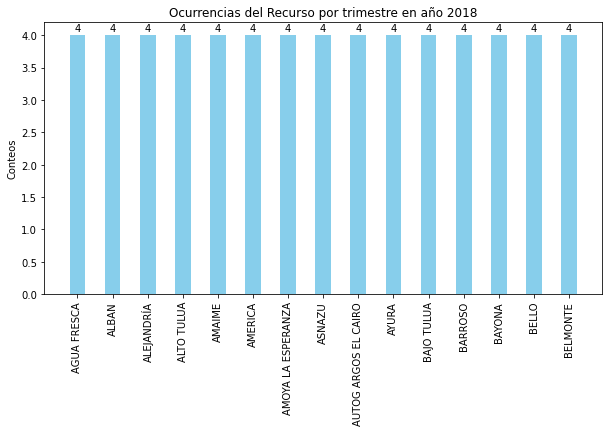

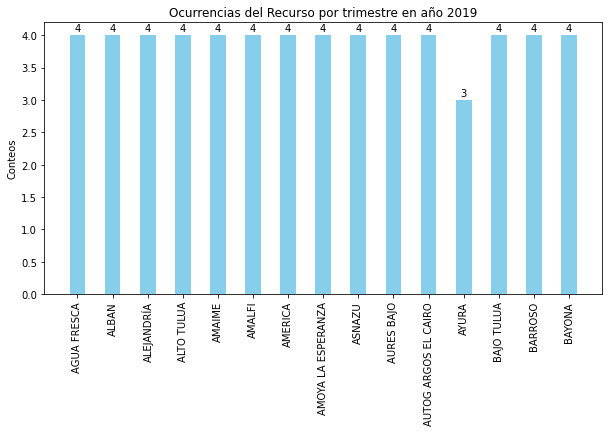

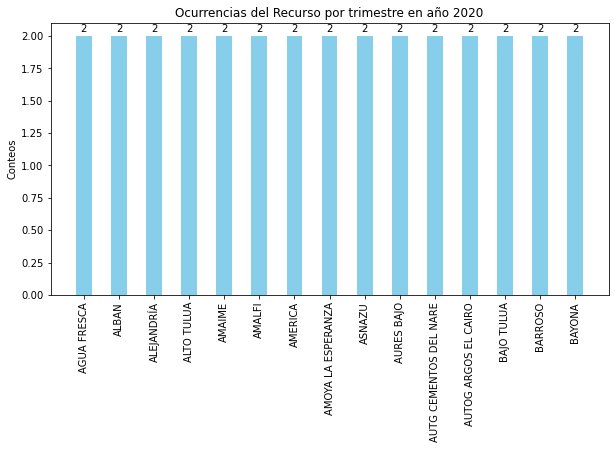

In [26]:
for key,value in conteo_dict.items():
    title = 'Ocurrencias del Recurso por trimestre en año {}'.format(key)
    labels = list(value.keys())[:15]
    values = list(value.values())[:15]
    plot_measures(values,labels,title,x_rotation=90,fig_size=(10,5))

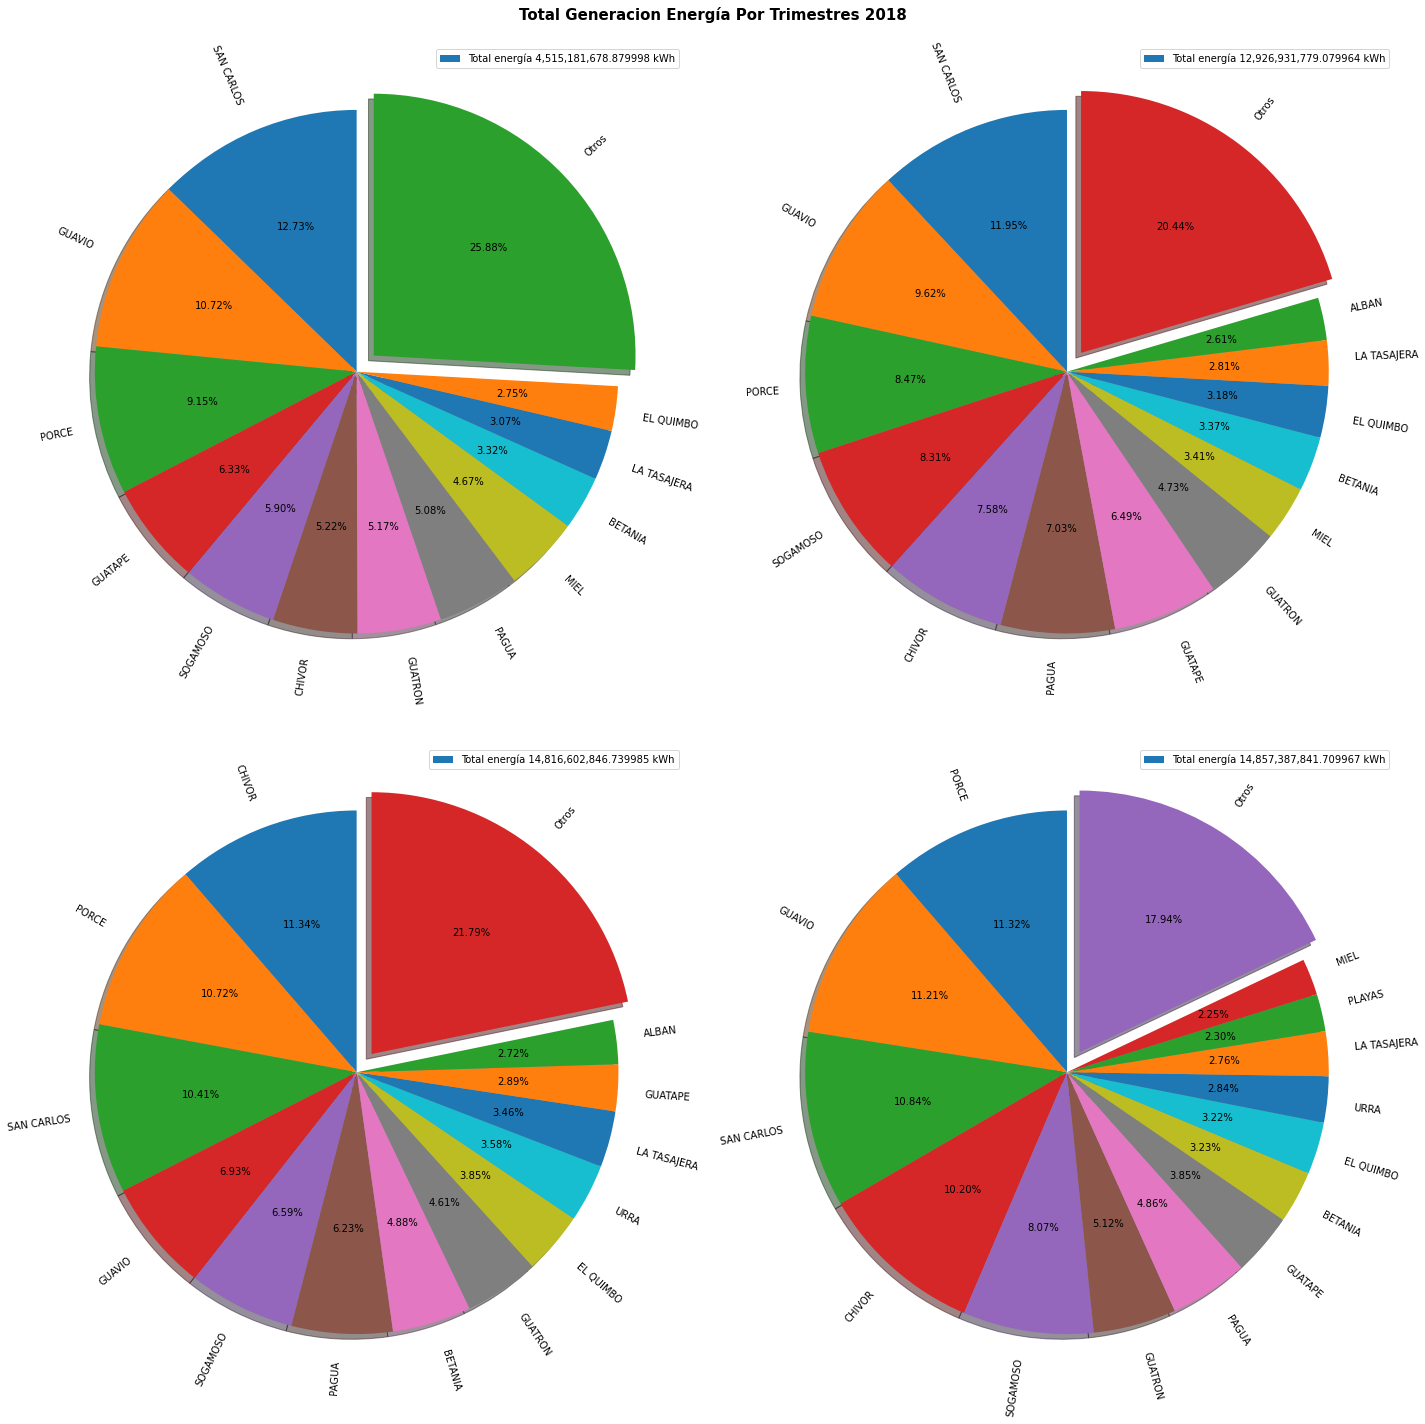

In [27]:
trimestres = ['2018-01-31','2018-04-30','2018-07-31','2018-10-31']
pintar_grafica(data_por_trimestre,trimestres,'2018',variable_general,variable_especifica)

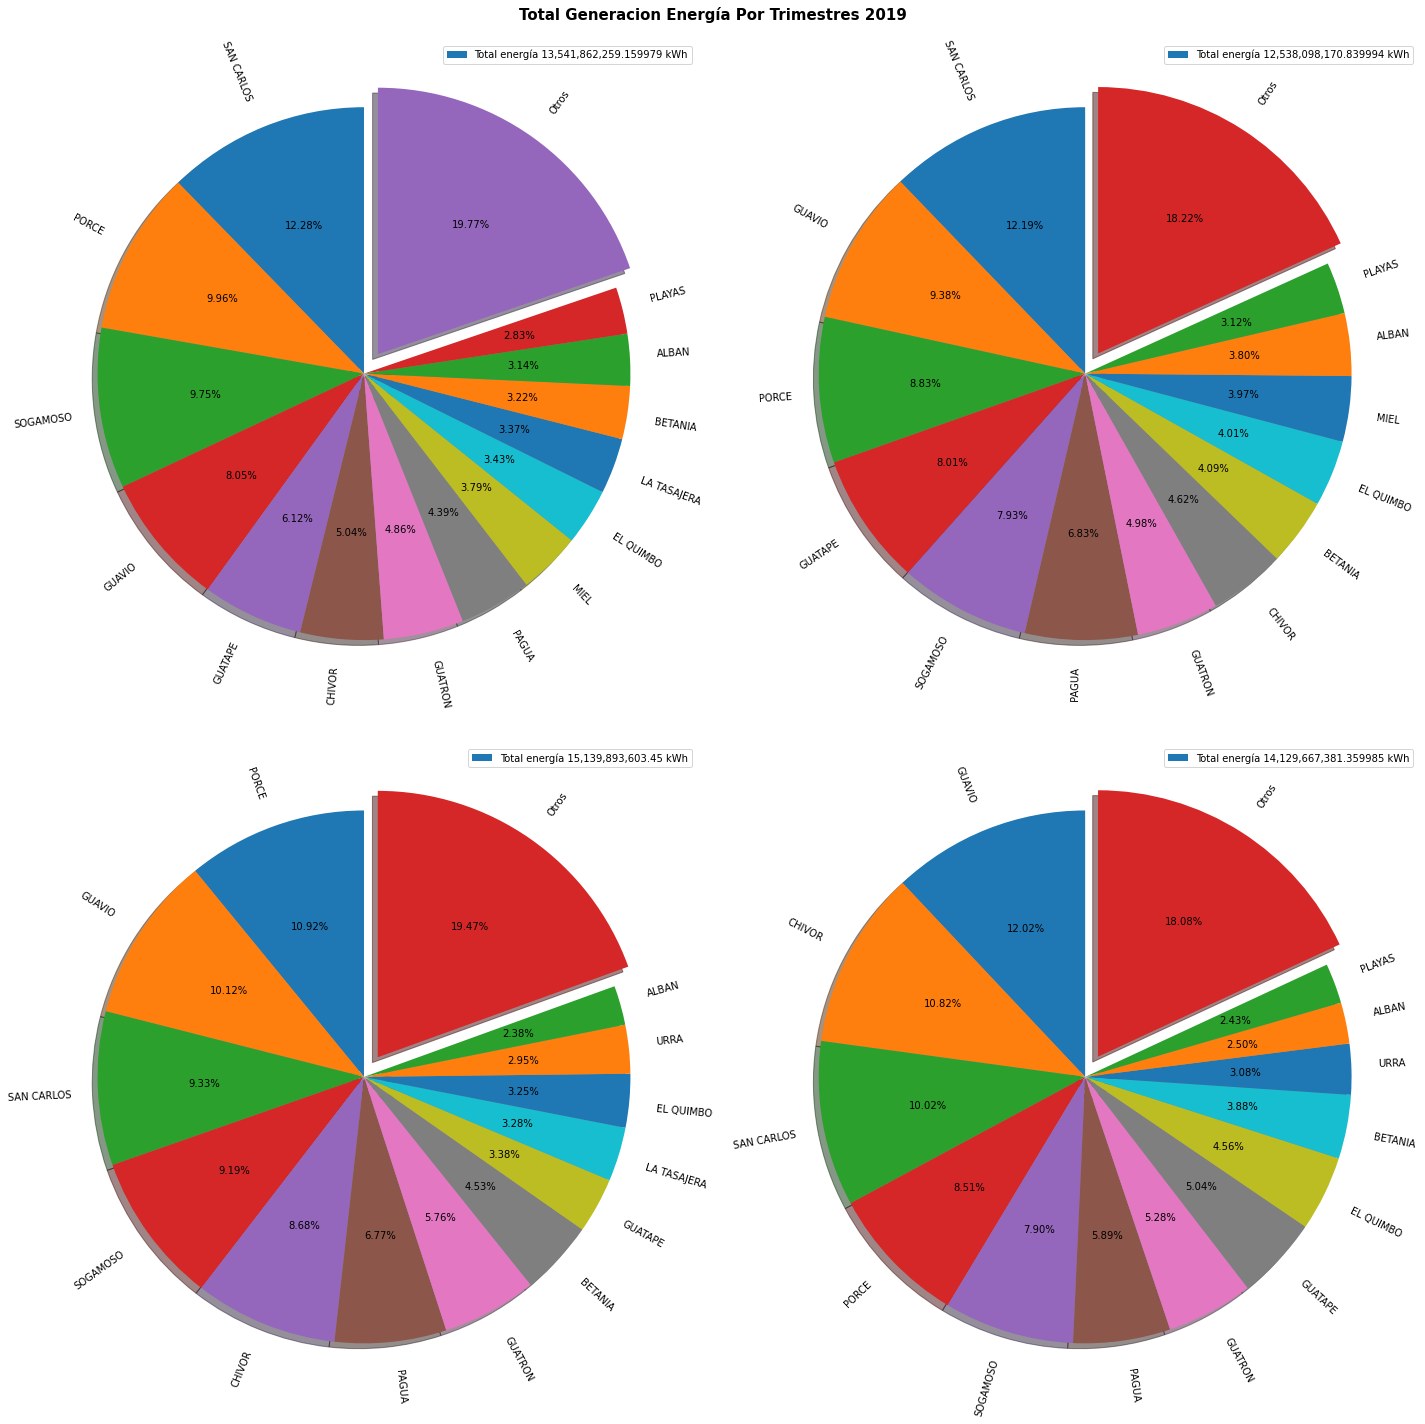

In [28]:
trimestres = ['2019-01-31','2019-04-30','2019-07-31','2019-10-31']
pintar_grafica(data_por_trimestre,trimestres,'2019',variable_general,variable_especifica)

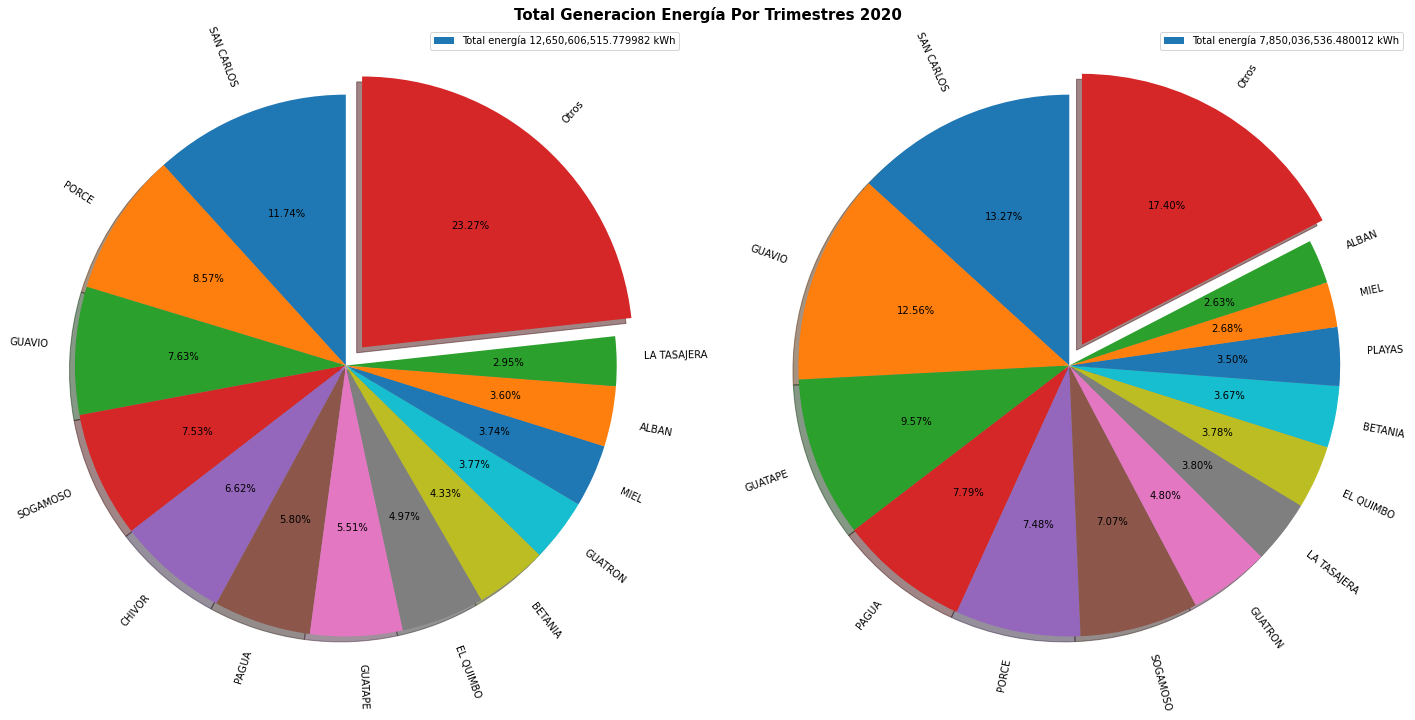

In [29]:
trimestres = ['2020-01-31','2020-04-30']
pintar_grafica(data_por_trimestre,trimestres,'2020',variable_general,variable_especifica)

## Código Agente

In [30]:
variable_especifica = 'Código Agente'

In [31]:
data_por_trimestre = filter_df.groupby(pd.Grouper(key="Fecha", freq="3M")).apply(lambda x: energia_por_trimestre(x,'Código Agente'))
trimestres = pd.unique(data_por_trimestre.index.get_level_values('Fecha'))

conteo_dict = conteo_ocurrencias(data_por_trimestre,trimestres,'Código Agente')

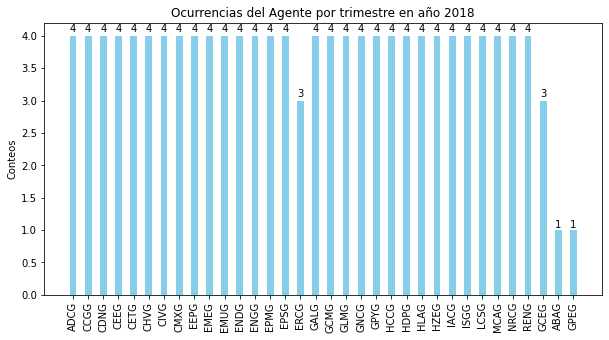

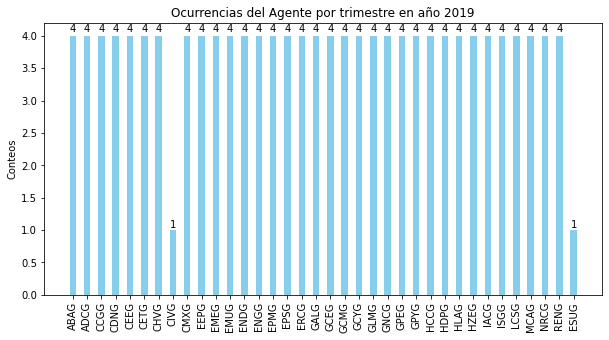

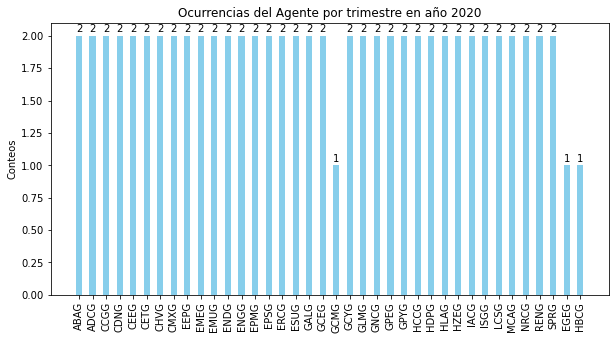

In [32]:
for key,value in conteo_dict.items():
    title = 'Ocurrencias del Agente por trimestre en año {}'.format(key)
    labels = value.keys()
    values = value.values()
    plot_measures(values,labels,title,x_rotation=90,fig_size=(10,5))

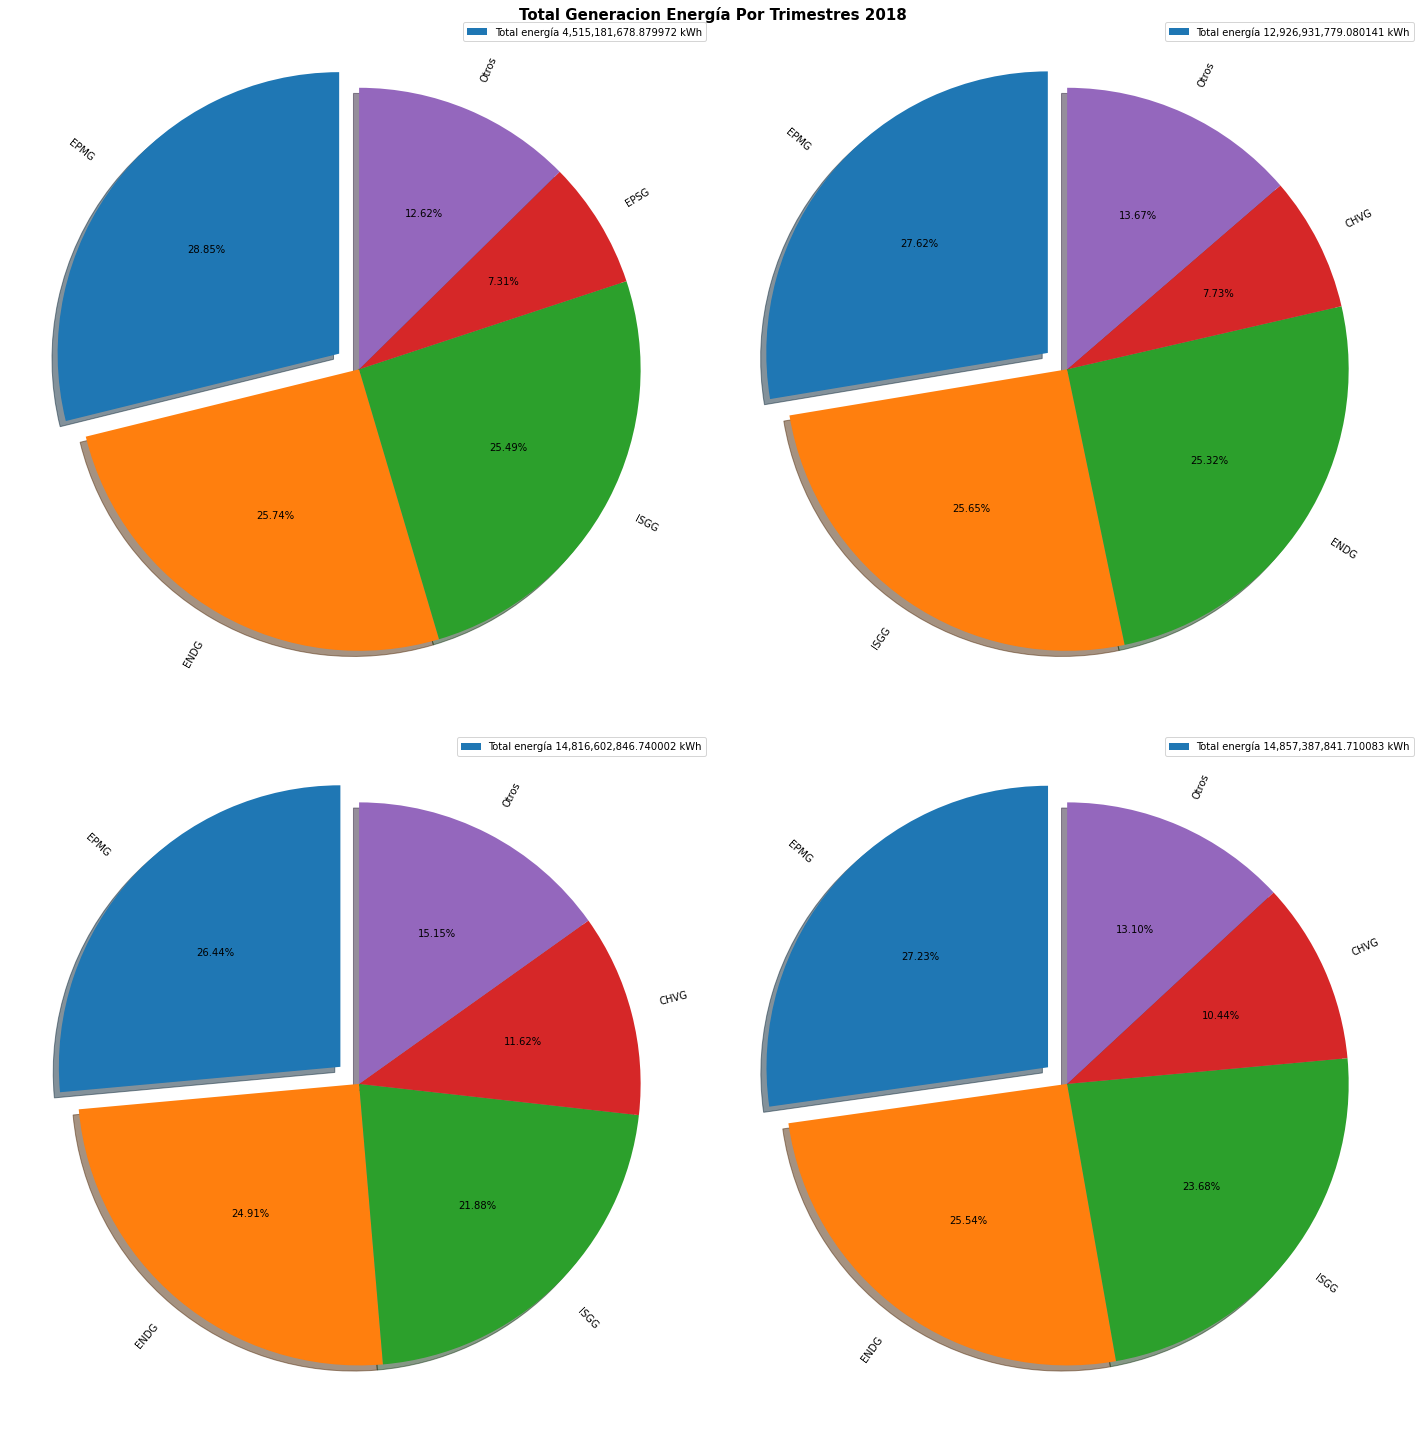

In [33]:
trimestres = ['2018-01-31','2018-04-30','2018-07-31','2018-10-31']
pintar_grafica(data_por_trimestre,trimestres,'2018',variable_general,variable_especifica)

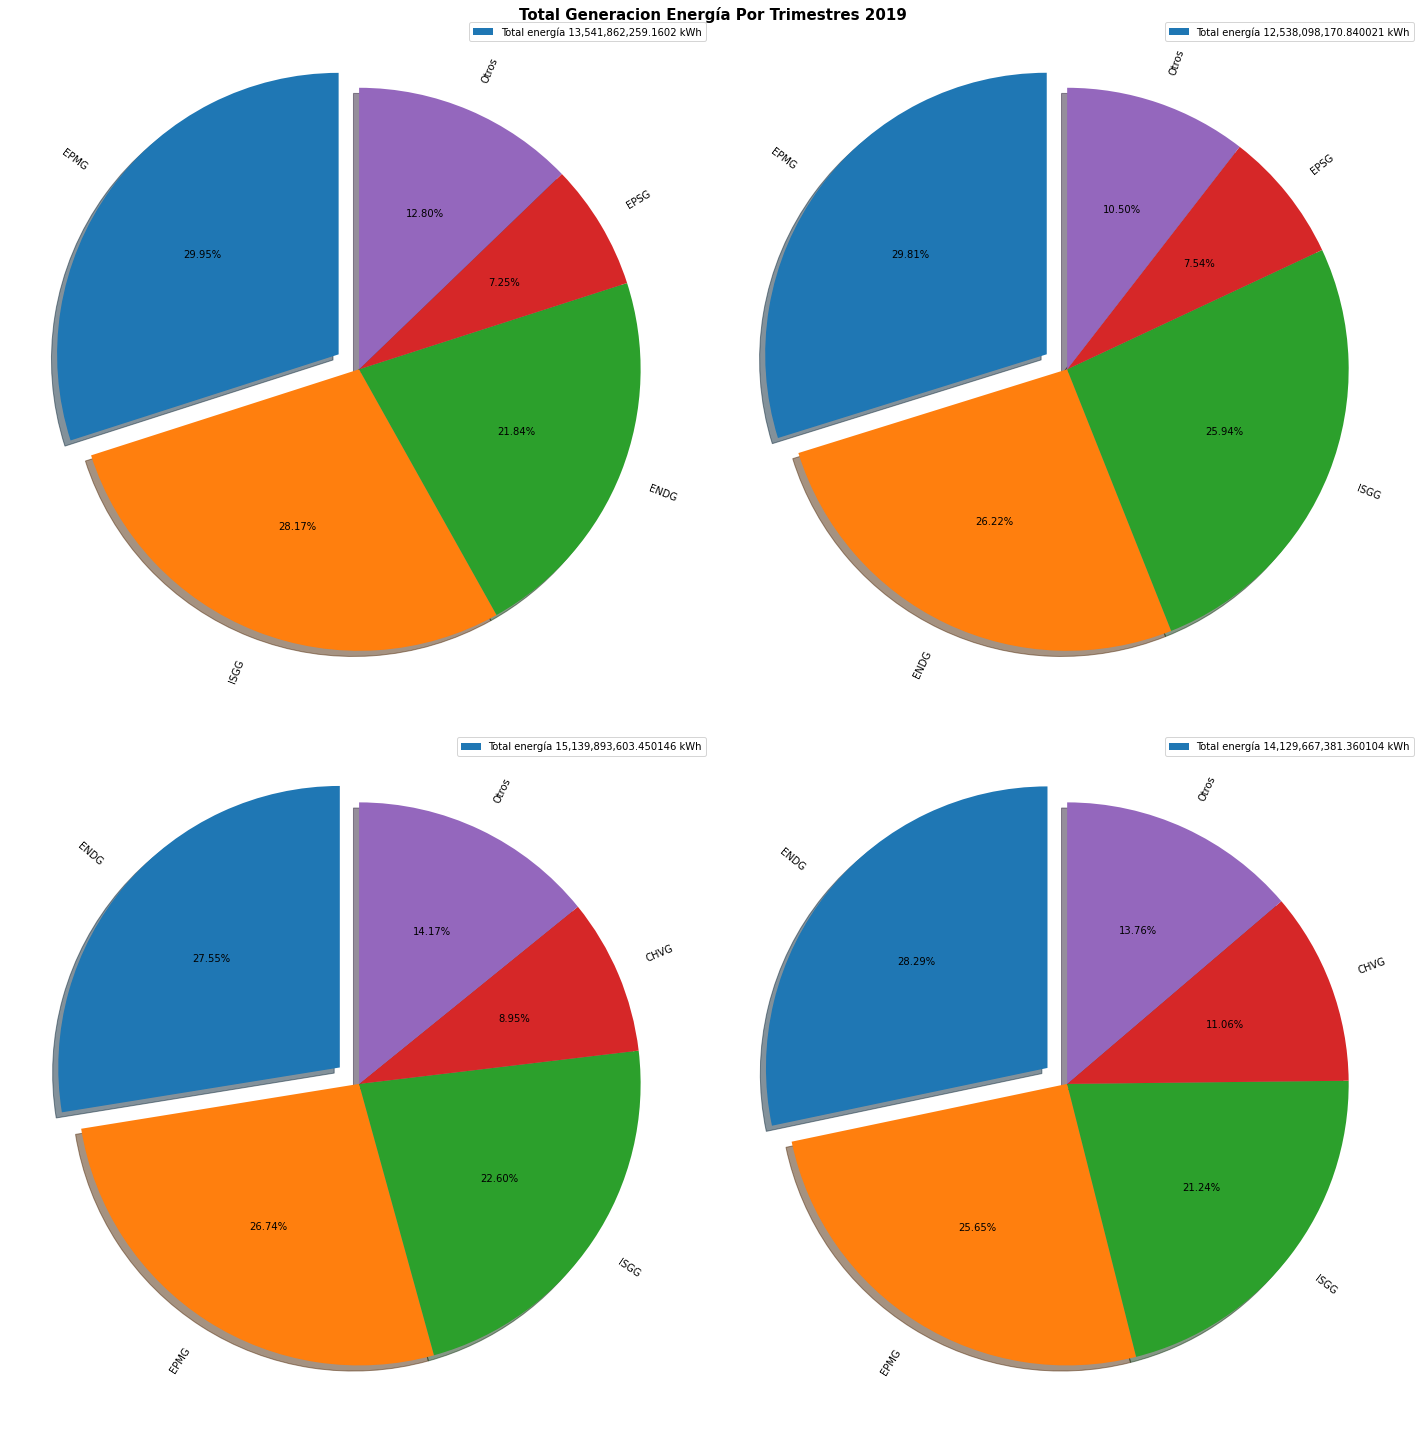

In [34]:
trimestres = ['2019-01-31','2019-04-30','2019-07-31','2019-10-31']
pintar_grafica(data_por_trimestre,trimestres,'2019',variable_general,variable_especifica)

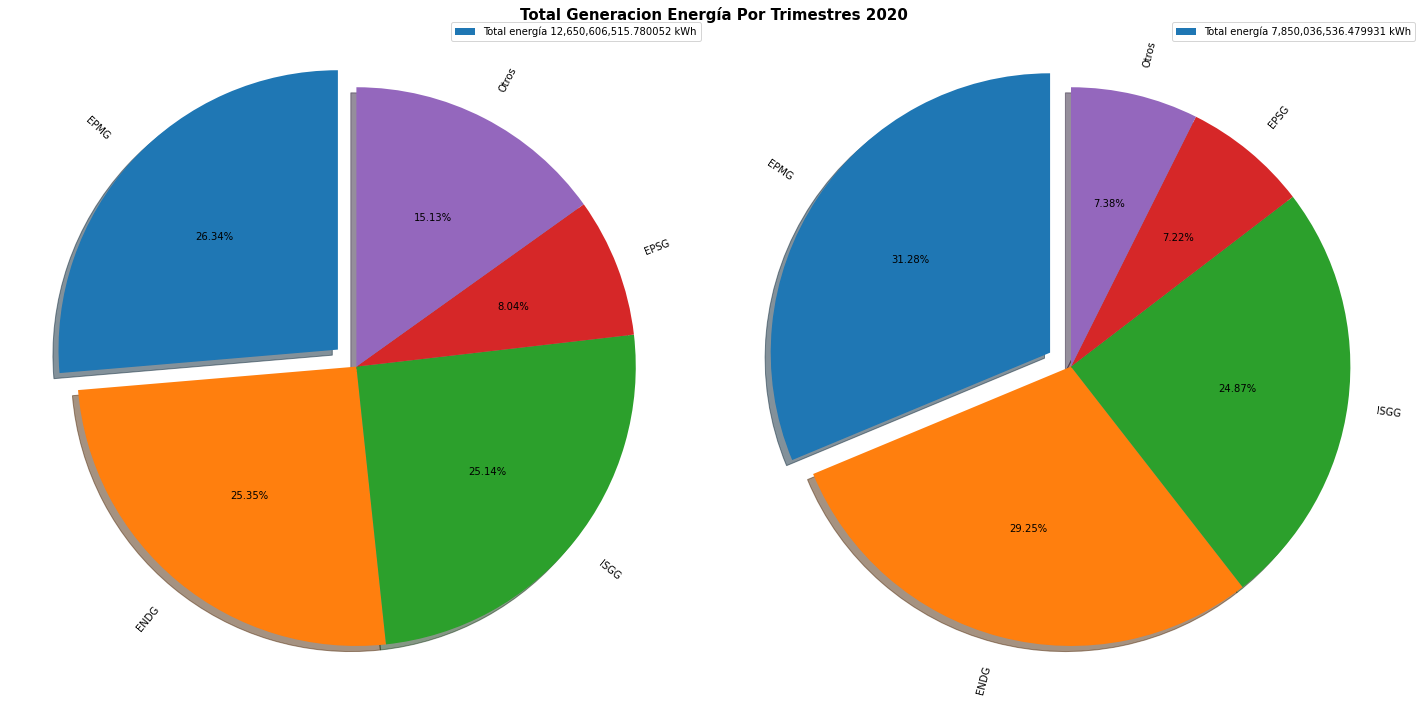

In [35]:
trimestres = ['2020-01-31','2020-04-30']
pintar_grafica(data_por_trimestre,trimestres,'2020',variable_general,variable_especifica)